# Backstory

Huff construction company has been hired to complete some repairs on the Lexington Avenue/59th Street subway station entrance in Manhattan. The work is long overdue, as it hasn't been renovated since October of 1973 and the tiles on the walls are cracked and falling off into the stairwell. However, the BMT Broadway Line is particularly busy, and this station complex is the fourteenth-busiest in the system, so the company will want to reduce the traffic impact on the rest of the line as much as possible. They will need to close the station during repairs for a total of 16 non-consecutive hours and plan to do their work sometime during the month of October 2021. When would be the best days/times for Huff construction workers to close the station in order to minimize the number of travelers who are displaced?

# Load and View the Data

In [1]:
# load in the required packages
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import datetime
import matplotlib.pyplot as plt

Collect data from October 2015-2020 and include Sept 30 to deal with cumulative data.

In [2]:
# import the database from SQLite
engine = create_engine("sqlite:///mta_data.db")
df = pd.read_sql("SELECT * FROM mta_data WHERE DATE LIKE '10%' OR DATE LIKE '09/30%';", engine)

Data for one of the turnstiles at 59 ST was missing in 2015. Looking into it a bit more, I discovered that turnstile is called LEXINGTON AVE that year.

In [3]:
# only collect the data from the correct station (59 ST or LEXINGTON AVE at one specific turnstile in 2015)
Lex_mask = (df["C/A"] == "A002") & (df["UNIT"] == "R051") & (df["STATION"] == "LEXINGTON AVE")
df = df[(df["STATION"] == "59 ST") | Lex_mask]

Data is collected every four hours, but sometimes there are times in between. Looks like these are just additional information that may be unnecessary and removal would not affect the cumulative results.

In [4]:
# filter so it only includes data at times 00:00:00, 04:00:00, 08:00:00, 12:00:00, 16:00:00, and 20:00:00
df = df[((df["TIME"] == "00:00:00") | (df["TIME"] == "04:00:00") | (df["TIME"] == "08:00:00") | \
(df["TIME"] == "12:00:00") | (df["TIME"] == "16:00:00") | (df["TIME"] == "20:00:00"))]

In [5]:
# view size of dataframe and look for NAN values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60575 entries, 0 to 5468397
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   C/A       60575 non-null  object
 1   UNIT      60575 non-null  object
 2   SCP       60575 non-null  object
 3   STATION   60575 non-null  object
 4   LINENAME  60575 non-null  object
 5   DIVISION  60575 non-null  object
 6   DATE      60575 non-null  object
 7   TIME      60575 non-null  object
 8   DESC      60575 non-null  object
 9   ENTRIES   60575 non-null  int64 
 10  EXITS     60575 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 5.5+ MB


In [6]:
# look at the top
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,00:00:00,REGULAR,7481098,2545767
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,04:00:00,REGULAR,7481103,2545767
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,08:00:00,REGULAR,7481117,2545786
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,12:00:00,REGULAR,7481158,2545831
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,16:00:00,REGULAR,7481285,2545868


In [7]:
# look at the bottom
df.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
5468393,R245A,R051,01-06-01,59 ST,456NQR,IRT,10/02/2015,04:00:00,REGULAR,125710,1988505
5468394,R245A,R051,01-06-01,59 ST,456NQR,IRT,10/02/2015,08:00:00,REGULAR,125715,1988548
5468395,R245A,R051,01-06-01,59 ST,456NQR,IRT,10/02/2015,12:00:00,REGULAR,125730,1989100
5468396,R245A,R051,01-06-01,59 ST,456NQR,IRT,10/02/2015,16:00:00,REGULAR,125771,1989743
5468397,R245A,R051,01-06-01,59 ST,456NQR,IRT,10/02/2015,20:00:00,REGULAR,125964,1990663


In [8]:
# look at a random sample
df.sample(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1776391,C021,R212,00-00-03,59 ST,NRW,BMT,10/04/2019,00:00:00,REGULAR,157883,122578
2207618,R244A,R050,01-06-01,59 ST,456NQRW,IRT,10/23/2018,00:00:00,REGULAR,4683048,2894358
2472260,C022,R212,01-05-01,59 ST,NRW,BMT,10/10/2018,04:00:00,REGULAR,0,413
3997049,A002,R051,02-00-01,59 ST,NQR456,BMT,10/18/2016,12:00:00,REGULAR,5390535,1183391
5168145,R245,R051,00-05-01,59 ST,456NQR,IRT,10/13/2015,16:00:00,REGULAR,11374723,4996467
4532167,R245,R051,00-03-03,59 ST,456NQR,IRT,10/06/2016,00:00:00,REGULAR,5790330,12095714
55063,C021,R212,00-00-01,59 ST,NRW,BMT,10/26/2020,08:00:00,REGULAR,8430343,5870206
3804551,A002,R051,02-00-01,59 ST,NQR456,BMT,10/28/2016,08:00:00,REGULAR,5403738,1186274
4189237,A002,R051,02-05-01,59 ST,NQR456,BMT,10/08/2016,00:00:00,REGULAR,0,707
3152183,C021,R212,00-00-01,59 ST,NRW,BMT,10/16/2017,16:00:00,REGULAR,7325366,5189520


# Edit the Data

In [9]:
# create a turnstile column for easier grouping
df["Turnstile"] = df["C/A"] + " " + df["UNIT"] + " " + df["SCP"]
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Turnstile
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,00:00:00,REGULAR,7481098,2545767,A002 R051 02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,04:00:00,REGULAR,7481103,2545767,A002 R051 02-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,08:00:00,REGULAR,7481117,2545786,A002 R051 02-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,12:00:00,REGULAR,7481158,2545831,A002 R051 02-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,16:00:00,REGULAR,7481285,2545868,A002 R051 02-00-00


In [10]:
# convert the DATE and TIME columns to a datetime object
df["Date_Time"] = pd.to_datetime(df["DATE"] + " " + df["TIME"])
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Turnstile,Date_Time
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,00:00:00,REGULAR,7481098,2545767,A002 R051 02-00-00,2020-10-31 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,04:00:00,REGULAR,7481103,2545767,A002 R051 02-00-00,2020-10-31 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,08:00:00,REGULAR,7481117,2545786,A002 R051 02-00-00,2020-10-31 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,12:00:00,REGULAR,7481158,2545831,A002 R051 02-00-00,2020-10-31 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,16:00:00,REGULAR,7481285,2545868,A002 R051 02-00-00,2020-10-31 16:00:00


In [11]:
# sort by turnstile and then by date_time so they will be in chronological order for each
df.sort_values(["Turnstile", "Date_Time"], inplace=True)

In [12]:
# create previous entries and exits columns and list the previous date_time as well
df["Prev_Date_Time"] = df.groupby(["Turnstile"], as_index=False).Date_Time.shift(1)
df["Prev_Entries"] = df.groupby(["Turnstile"], as_index=False).ENTRIES.shift(1)
df["Prev_Exits"] = df.groupby(["Turnstile"], as_index=False).EXITS.shift(1)

In [13]:
# get rid of Sept because we don't need that anymore
df = df[df["Date_Time"].dt.month != 9]

In [14]:
# use these functions to subtract old counts from new counts for entries and exits
def get_entry_counts(row, max_count):
    if row["Prev_Date_Time"] + datetime.timedelta(hours=4) == row["Date_Time"]:
        # need to make sure that the previous entry was directly before it
        count = row["ENTRIES"] - row["Prev_Entries"]
        if count < 0:
            # might be listed in reverse
            count = -count
        if count > max_count:
            # might have been reset
            count = min(row["ENTRIES"], row["Prev_Entries"])
        if count > max_count:
            # might be something else going on
            count = np.nan
    else:
        count = np.nan
    return count

def get_exit_counts(row, max_count):
    if row["Prev_Date_Time"] + datetime.timedelta(hours=4) == row["Date_Time"]:
        # need to make sure that the previous exit was directly before it
        count = row["EXITS"] - row["Prev_Exits"]
        if count < 0:
            # might be listed in reverse
            count = -count
        if count > max_count:
            # might have been reset
            count = min(row["EXITS"], row["Prev_Exits"])
        if count > max_count:
            # might be something else going on
            count = np.nan
    else:
        count = np.nan
    return count

Create rows showing the new entrances and exits since the last count (not cumulative counts).

In [15]:
# create columns with the new entries and exits
df["New_Entries"] = df.apply(get_entry_counts, axis=1, max_count=10000)
df["New_Exits"] = df.apply(get_exit_counts, axis=1, max_count=10000)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Turnstile,Date_Time,Prev_Date_Time,Prev_Entries,Prev_Exits,New_Entries,New_Exits
5403092,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,00:00:00,REGULAR,5335226,1802762,A002 R051 02-00-00,2015-10-01 00:00:00,2015-09-30 20:00:00,5334936.0,1802733.0,290.0,29.0
5403093,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,04:00:00,REGULAR,5335247,1802768,A002 R051 02-00-00,2015-10-01 04:00:00,2015-10-01 00:00:00,5335226.0,1802762.0,21.0,6.0
5403094,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,08:00:00,REGULAR,5335291,1802877,A002 R051 02-00-00,2015-10-01 08:00:00,2015-10-01 04:00:00,5335247.0,1802768.0,44.0,109.0
5403095,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,12:00:00,REGULAR,5335504,1803218,A002 R051 02-00-00,2015-10-01 12:00:00,2015-10-01 08:00:00,5335291.0,1802877.0,213.0,341.0
5403096,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,16:00:00,REGULAR,5335826,1803300,A002 R051 02-00-00,2015-10-01 16:00:00,2015-10-01 12:00:00,5335504.0,1803218.0,322.0,82.0


Now that we know the new values for each entry and exit, we can combine them together to figure out the total amount of traffic going in and out.

In [16]:
# merge the New_Entries and New_Exits column into a new one called Traffic
df["Traffic"] = df["New_Entries"] + df["New_Exits"]
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Turnstile,Date_Time,Prev_Date_Time,Prev_Entries,Prev_Exits,New_Entries,New_Exits,Traffic
5403092,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,00:00:00,REGULAR,5335226,1802762,A002 R051 02-00-00,2015-10-01 00:00:00,2015-09-30 20:00:00,5334936.0,1802733.0,290.0,29.0,319.0
5403093,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,04:00:00,REGULAR,5335247,1802768,A002 R051 02-00-00,2015-10-01 04:00:00,2015-10-01 00:00:00,5335226.0,1802762.0,21.0,6.0,27.0
5403094,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,08:00:00,REGULAR,5335291,1802877,A002 R051 02-00-00,2015-10-01 08:00:00,2015-10-01 04:00:00,5335247.0,1802768.0,44.0,109.0,153.0
5403095,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,12:00:00,REGULAR,5335504,1803218,A002 R051 02-00-00,2015-10-01 12:00:00,2015-10-01 08:00:00,5335291.0,1802877.0,213.0,341.0,554.0
5403096,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/01/2015,16:00:00,REGULAR,5335826,1803300,A002 R051 02-00-00,2015-10-01 16:00:00,2015-10-01 12:00:00,5335504.0,1803218.0,322.0,82.0,404.0


It doesn't really matter which turnstiles people are going in and out of because it is all at the same station and will all be blocked by construction anyway. Instead, add up everything for the same date and time.

In [17]:
# reduce the dataframe to combine the ones with the same Date_Time
df = df.groupby("Date_Time", as_index=False).Traffic.sum()
df.head()

,Date_Time,Traffic
0,2015-10-01 00:00:00,16381.0
1,2015-10-01 04:00:00,2196.0
2,2015-10-01 08:00:00,16329.0
3,2015-10-01 12:00:00,41571.0
4,2015-10-01 16:00:00,33118.0


In [18]:
# create Weekday, Year, Day, Time, and Week columns using the Date_Time column
weekdays = np.array(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
df["Weekday"] = weekdays[np.array(df["Date_Time"].dt.weekday)]
df["Year"] = df["Date_Time"].dt.year
df["Day"] = df["Date_Time"].dt.day
df["Time"] = df["Date_Time"].dt.strftime("%H:%M:%S")
df["Week"] = df["Date_Time"].dt.isocalendar().week
df.head()

,Date_Time,Traffic,Weekday,Year,Day,Time,Week
0,2015-10-01 00:00:00,16381.0,Thursday,2015,1,00:00:00,40
1,2015-10-01 04:00:00,2196.0,Thursday,2015,1,04:00:00,40
2,2015-10-01 08:00:00,16329.0,Thursday,2015,1,08:00:00,40
3,2015-10-01 12:00:00,41571.0,Thursday,2015,1,12:00:00,40
4,2015-10-01 16:00:00,33118.0,Thursday,2015,1,16:00:00,40


# Create Plots

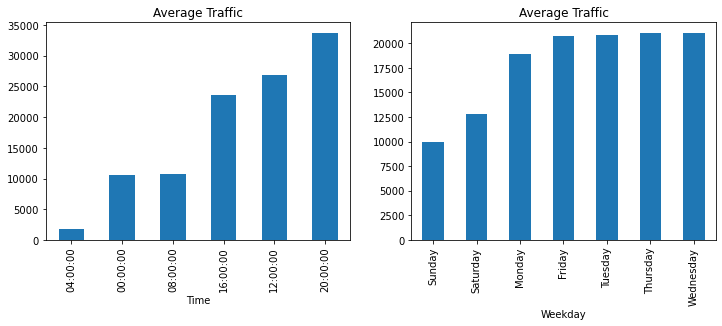

In [19]:
# create a bar chart of the average entries and exits at each time of day and on each weekday
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
df.groupby(["Time"]).mean()["Traffic"].sort_values().plot(kind="bar", title="Average Traffic")

plt.subplot(1,2,2)
df.groupby(["Weekday"]).mean()["Traffic"].sort_values().plot(kind="bar", title="Average Traffic");

In [20]:
# look at average data grouped by Weekday and then by Time
df.groupby(["Weekday","Time"]).mean().loc[:,["Traffic"]].sort_values("Traffic").head(10)

,,Traffic
Weekday,Time,
Monday,04:00:00,1263.222222
Tuesday,04:00:00,1449.962963
Thursday,04:00:00,1628.111111
Wednesday,04:00:00,1634.423077
Friday,04:00:00,1863.307692
Sunday,04:00:00,2415.884615
Saturday,04:00:00,2549.851852
Sunday,08:00:00,3037.115385
Saturday,08:00:00,4845.037037


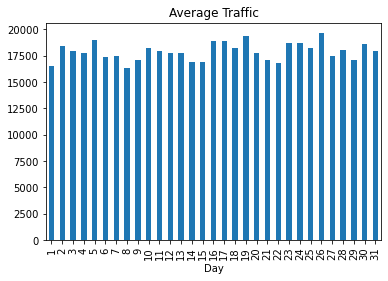

In [21]:
# create a bar chart of the average entries and exits on each day of the month
df.groupby(["Day"]).mean()["Traffic"].plot(kind="bar", title="Average Traffic");

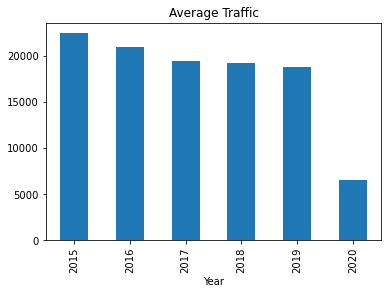

In [22]:
# create a bar chart of the average entries and exits sorted by year
df.groupby(["Year"]).mean()["Traffic"].plot(kind="bar", title="Average Traffic");

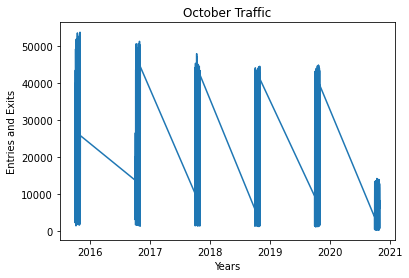

In [23]:
# create a line plot of the traffic over time (only with data from each October)
plt.plot(df["Date_Time"], df["Traffic"])
plt.xlabel("Years")
plt.ylabel("Entries and Exits")
plt.title("October Traffic");

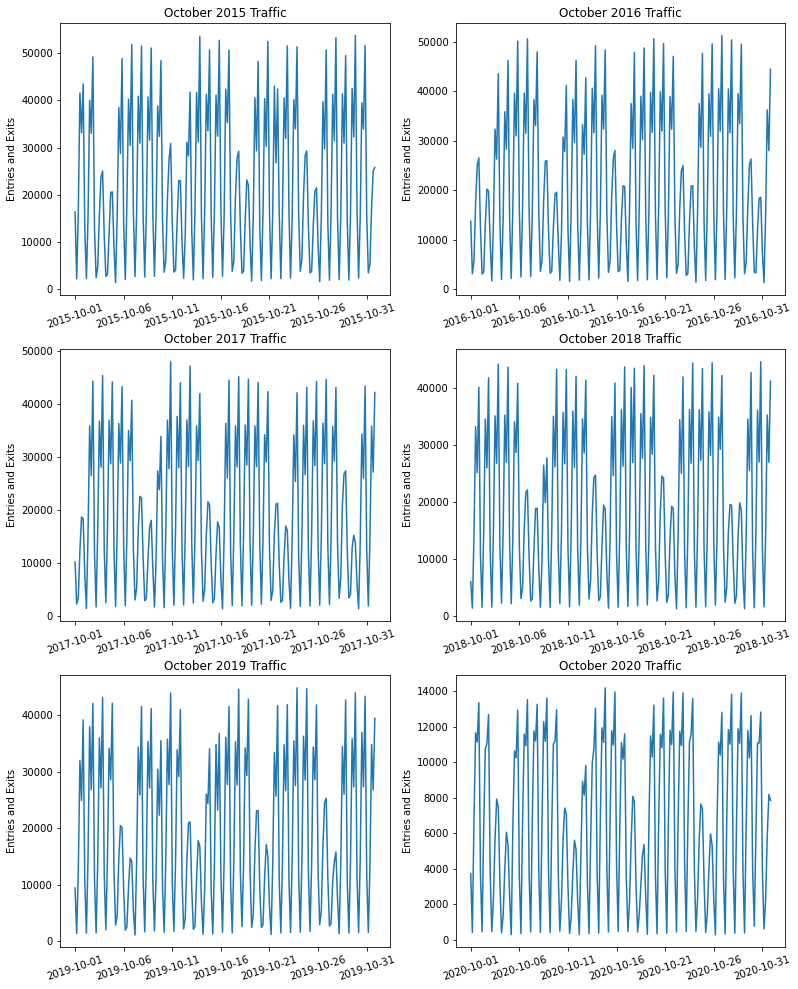

In [24]:
# create line plots of the traffic over time in each October 2015-2020
plt.figure(figsize=(13,17))
for i,j in enumerate(np.arange(2015, 2021)):
    plt.subplot(3,2,i+1)
    plt.plot(df[df["Year"] == j]["Date_Time"], df[df["Year"] == j]["Traffic"])
    plt.ylabel("Entries and Exits")
    plt.title("October " + str(j) + " Traffic")
    plt.xticks(np.arange(np.datetime64(str(j) + "-10-01"), np.datetime64(str(j) + "-11-01"), 5), rotation=18);

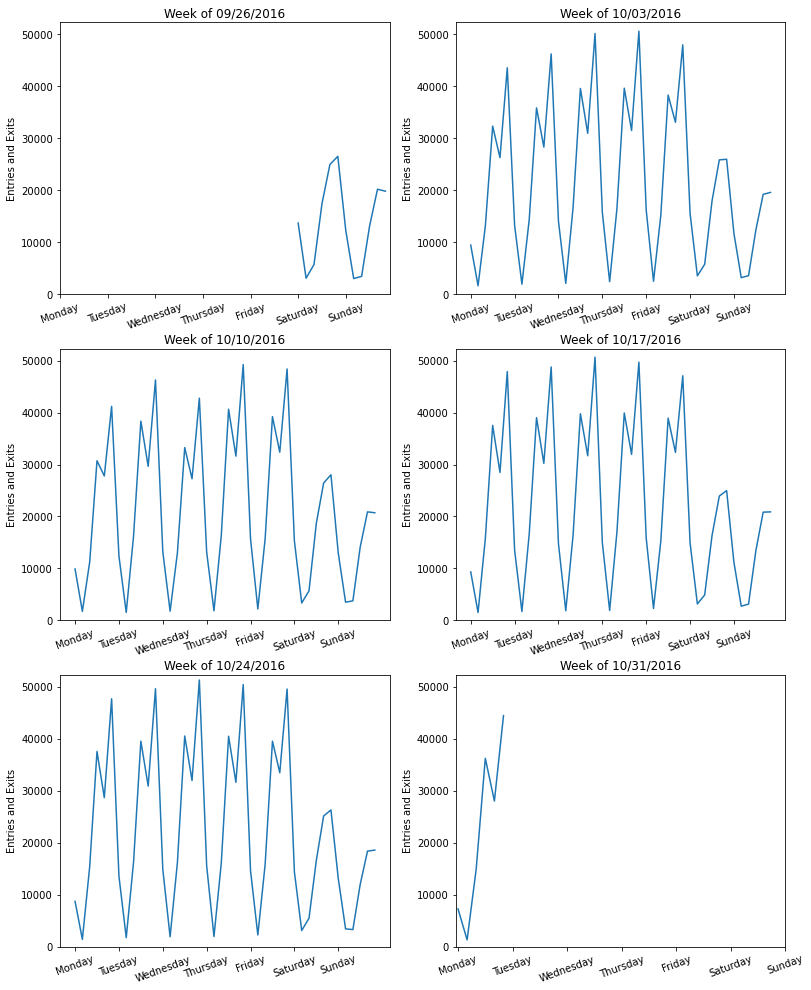

In [25]:
# create line plots of the traffic over time in each week of October (select the year of choice)

year_choice = 2016

# find the first monday
first_day = datetime.datetime(year_choice,10,1)
first_monday = first_day - datetime.timedelta(days=first_day.weekday())

plt.figure(figsize=(13,17))
for i,j in enumerate(df[(df["Year"]==year_choice)]["Week"].sort_values().unique()):
    
    # find the appropriate start and end days of the week
    monday = first_monday + datetime.timedelta(days=7)*i
    next_mon = monday + datetime.timedelta(days=7)
    
    # create the plots
    plt.subplot(3,2,i+1)
    mask = (df["Year"]==year_choice) & (df["Week"]==j)
    plt.plot(df[mask]["Date_Time"], df[mask]["Traffic"])
    plt.ylabel("Entries and Exits")
    plt.title("Week of " + monday.strftime("%m/%d/%Y"))
    plt.xticks(np.arange(np.datetime64(monday.strftime("%Y-%m-%d")), np.datetime64(next_mon.strftime("%Y-%m-%d"))),
               ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=20)
    plt.ylim(0, df[(df["Year"]==year_choice)]["Traffic"].max()+1000);

# Results

First look at summary statistics to search for traffic patterns:

- The time block from midnight to 4am is the most suitable for closure of the station.
- The days of the week with the least amount of traffic are Sunday and Saturday.
- However, grouping the data by day of the week and then by time shows that the 4am time slot on any weekday would be best (better than 4am on Saturday or Sunday, interestingly).

Then dig deeper into the raw data to understand why this is the case:

- Looking at data across all Octobers 2015-2020 is difficult to understand what is going on.
- So zoom in on a particular year and it becomes a bit more clear that there are peaks (weekdays) and valleys (weekends). Each year looks pretty much the same (2020 is just smaller numbers of traffic).
- Now zoom in on a particular week of any given October. It is pretty easy to see that weekdays have more extreme highs and lows (but especially highs) than the weekends. Looks like each weekday has two peaks, one for the morning traffic and one for the evening traffic, and one trough for the nighttime traffic. The weekend days have one peak and one trough, with Sunday being lower than Saturday. Each week of October looks pretty much the same and for all years studied.
- This makes sense. While people are more likely to be using the subway for business during the daytime on weekdays than weekends, late hours on the weekends would be a bit more popular than late hours during the week.

Now look at some stations nearby:

- Conducting this same investigation on traffic at stations 5 AV/59 ST (aka 5 AVE-59 ST) which is to the west, 51 ST which is to the south, and LEXINGTON AV/63 which is to the north, showed similar patterns.
- Nighttime hours and weekends were the lowest and the raw data looked very similar to the Lexington Avenue/59th Street station.

# Concluding Remarks

- In summary, choosing to close the Lexington Avenue/59th Street station during the 12am-4am time block on weekdays would be not only the best time for this particular station, but also a good time for surrounding stations to accommodate the displaced traffic.